# AI Art with Style Transfer

First, start out with some imports.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras import backend
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from scipy.optimize import fmin_l_bfgs_b

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


Specify the paths for the content image, the style image, and the output image.

In [2]:
c_image_path = './initial_images/content_image.jpg'
s_image_path = './initial_images/style_image.jpg'
o_image_directory = './output/'

Here are the content and style images chosen.

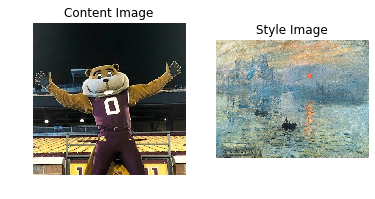

In [3]:
plt.subplot(1, 2, 1).imshow(load_img(path=c_image_path))
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2).imshow(load_img(path=s_image_path))
plt.title('Style Image')
plt.axis('off')
plt.show()

Image proccessing

In [4]:
target_height = 512
target_width = 512
target_size = (target_height, target_width)

c_image_original = Image.open(c_image_path)
c_image_original_size = c_image_original.size
c_image = load_img(path=c_image_path, target_size=target_size)
c_image_arr = img_to_array(c_image)
c_image_arr = backend.variable(preprocess_input(np.expand_dims(c_image_arr, axis=0)), dtype='float32')

s_image = load_img(path=s_image_path, target_size=target_size)
s_image_arr = img_to_array(s_image)
s_image_arr = backend.variable(preprocess_input(np.expand_dims(s_image_arr, axis=0)), dtype='float32')

o_image_initial = np.random.randint(256, size=(target_width, target_height, 3)).astype('float64')
o_image_initial = preprocess_input(np.expand_dims(o_image_initial, axis=0))

o_image_placeholder = backend.placeholder(shape=(1, target_width, target_height, 3))

## Content Loss
The content loss function must be formulated in order to ensure that the generated image <i>x</i> retains some of the "global" characteristics of the content image <i>p</i>. To achieve this, the content loss function is defined as the mean squared error between the <b>feature representations</b> of <i>p</i> and <i>x</i>, respectively, at a given layer <i>l</i> within the neural network:

$$ L_c(p,x,l) = \frac{1}{2}\sum_{i,j}^{} (F^l_{i,j} - P^l_{i,j})^2 $$

<ul>
    <li><i>F</i> and <i>P</i> and are matrices of size <i>N</i> x <i>M</i></li>
    <li><i>N</i> is the number of filters in layer <i>l</i> and <i>M</i> is the number of spatial elements in the feature map (height times width) for layer <i>l</i></li>
    <li><i>F</i> contains the feature representation of <i>x</i> for layer <i>l</i></li>
    <li><i>P</i> contains the feature representation of <i>p</i> for layer <i>l</i></li>
</ul>

The output of a given layer within the neural network consists of so-called <b>feature maps</b>: differently filtered versions of the input image. We can directly visualise the information each layer contains about the input image by reconstructing the image only from the <b>feature maps</b> in that layer. Higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but do not constrain the exact pixel values of the reconstruction; in contrast, reconstructions from the lower layers simply reproduce the exact pixel values of the original image. We therefore refer to the feature responses in higher layers of the network as the <b>content or feature representation</b>.

In [5]:
def get_feature_reps(x, layer_names, model):
    """
    Get feature representations of input x for one or more layers in a given model.
    """
    feature_matrices = []
    for layer in layer_names:
        current_layer = model.get_layer(layer)
        feature_raw = current_layer.output
        feature_raw_shape = backend.shape(feature_raw).eval(session=tf_session)
        N_l = feature_raw_shape[-1]
        M_l = feature_raw_shape[1]*feature_raw_shape[2]
        feature_matrix = backend.reshape(feature_raw, (M_l, N_l))
        feature_matrix = backend.transpose(feature_matrix)
        feature_matrices.append(feature_matrix)
    return feature_matrices

In [6]:
def get_content_loss(F, P):
    content_loss = 0.5*backend.sum(backend.square(F - P))
    return content_loss

## Style Loss
Conversely, style loss is designed to preserve the stylisitc characteristics of the style image, <i>a</i>. As opposed to using the difference between feature representations, use the difference between Gram matrices from selected layers. The Gram matrix is a square matrix that contains the dot products between each vectorized filter in layer <i>l</i>, and it can therefore be thought of as a non-normalized correlation matrix for filters in the layer. The Gram matrix is defined as follows:
    
$$ G^l = F^l(F^l)^T $$

In [7]:
def get_gram_matrix(F):
    G = backend.dot(F, backend.transpose(F))
    return G

Then, the style loss contribution from layer <i>l</i> is

$$ E_l = \frac{1}{4N^2_lM^2_l} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2$$

where <i>A</i> is the Gram matrix for the style image <i>a</i> and <i>G</i> is the Gram matrix for the generated image <i>x</i>. Ascending layers in most convolutional networks such as VGG have increasingly larger receptive fields. As this receptive field grows, more large-scale characteristics of the input image are preserved. Because of this, multiple layers should be selected for “style” to incorporate both local and global stylistic qualities. To create a smooth blending between these different layers, we can assign a weight <i>w</i> to each layer, and define the total style loss as:

$$ L_s(a,x,l) = \sum_l^L w_lE_l $$

In [8]:
def get_style_loss(ws, Gs, As):
    style_loss = backend.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = backend.int_shape(G)[1]
        N_l = backend.int_shape(G)[0]
        G_gram = get_gram_matrix(G)
        A_gram = get_gram_matrix(A)
        style_loss += w*0.25*backend.sum(backend.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return style_loss

## Combining the Losses
Lastly, weighting coefficients need to be assigned to both the content and style loss functions and summed to get an overall loss function.

$$ L(p, a, x, l) = \alpha L_c(p,x,l) + \beta L_s(a, x, l) $$

$\alpha$ and $\beta$ are hyperparameters that weight the conent and style loss, respectively, and they can be used to tune the influence of both images on the generated image. The authors of the paper recomend setting $\alpha = 1$ and $\beta = 10,000$.

In [9]:
def get_total_loss(o_image_placeholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(o_image_placeholder, layer_names=[c_layer_name], model=o_model)[0]
    Gs = get_feature_reps(o_image_placeholder, layer_names=s_layer_names, model=o_model)
    content_loss = get_content_loss(F, P)
    style_loss = get_style_loss(ws, Gs, As)
    total_lass = alpha * content_loss + beta * style_loss
    return total_lass

## Implementation
To start changing the generated image to minimize the loss function, two more functions must be defined to use scipy and the keras backend:

1. A function to calculate the total loss.
2. A function to calculate the gradient.

Both functions are fed as input into a scipy optimization function as the objective and gradient functions respectively. In this case, the limited-memory BFGS algorithm is used. It is an optimization algorithm that approximates the BFGS algorithm using a limited amount of memory, and its goal is to minimize a differentiable, scalar function over unconstrained values of its input vector. For each of the content and style images, the feature representations are extracted to construct <i>P</i> and <i>A</i> (for each selected style layer), and weight the style layers uniformly. In practice, using more than 500 iterations of L-BFGS-B creates convincing visualizations.

In [10]:
def calculate_loss(o_image_arr):
    """
    Calculate total loss using backend.function
    """
    if o_image_arr.shape != (1, target_width, target_width, 3):
        o_image_arr = o_image_arr.reshape((1, target_width, target_height, 3))
    loss_function = backend.function([o_model.input], [get_total_loss(o_model.input)])
    return loss_function([o_image_arr])[0].astype('float64')

def get_gradient(o_image_arr):
    """
    Calculate the gradient of the loss function with respect to the generated image
    """
    if o_image_arr.shape != (1, target_width, target_height, 3):
        o_image_arr = o_image_arr.reshape((1, target_width, target_height, 3))
    gradient_function = backend.function([o_model.input], backend.gradients(get_total_loss(o_model.input), [o_model.input]))
    gradient = gradient_function([o_image_arr])[0].flatten().astype('float64')
    return gradient

Some functions must also be defined that process the result of minimizing the loss function:

In [11]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (target_width, target_height, 3):
        x = x.reshape((target_width, target_height, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x

def save_image(x, image_number, target_size=c_image_original_size):
    x_image = Image.fromarray(x)
    x_image = x_image.resize(target_size)
    x_image.save(o_image_directory + f'/image_{image_number}.jpg')
    return x_image

Now, the VGG16 models are initialized with the respective image tensors created earlier. Instead of setting `weights` to `None` (which randomly initializes the weights), `weights` is set to `'imagenet'` (which includes the pre-trained weights on ImageNet). 

In [12]:
tf_session = backend.get_session()
c_model = VGG16(include_top=False, weights='imagenet', input_tensor=c_image_arr)
s_model = VGG16(include_top=False, weights='imagenet', input_tensor=s_image_arr)
o_model = VGG16(include_top=False, weights='imagenet', input_tensor=o_image_placeholder)

Next, the layers used to get the feature repesentations are selected.

In [13]:
c_layer_name = 'block4_conv2'
s_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
]

In [14]:
P = get_feature_reps(x=c_image_arr, layer_names=[c_layer_name], model=c_model)[0]
As = get_feature_reps(x=s_image_arr, layer_names=s_layer_names, model=s_model)
ws = np.ones(len(s_layer_names)) / float(len(s_layer_names))

Finally, the image is created using the L-BFGS algorithm from scipy.

In [ ]:
iterations = 500
x_val = o_image_initial.flatten()

start = time.time()
x_output, f_minimum_val, info_dict = fmin_l_bfgs_b(func=calculate_loss, x0=x_val, fprime=get_gradient, maxiter=iterations, disp=True)
x_output = postprocess_array(x_output)
x_image = save_image(x_output, image_number=0)
print(f'Image saved')
end = time.time()
print(f'Time taken: {end - start}')